In [1]:
#from docopt import docopt
import numpy as np
import matplotlib.pyplot as plt
# Extract Features from a trained net via forward pass
import os
import sys
import tables as tb
import h5py as h5
from scipy import stats
import subprocess as sub
from sklearn.metrics import mean_squared_error as mse
import collections
import pickle

# dictionaries for summarized results
boxplot_config_r = collections.defaultdict(list)
boxplot_config_MSE = collections.defaultdict(list)

In [7]:
def plot_from_logs(train_file, valid_file, log_title):
    '''
    Training Log Header:
    #Iters Seconds TrainingLoss LearningRate

    Valid Log Header:
    #Iters Seconds TestAccuracy TestLoss

    :param train_file:
    :param valid_file:
    :return:
    '''
    #tX = np.loadtxt(train_file, skiprows=1)    
    #vX = np.loadtxt(valid_file, skiprows=1)
    tX = np.genfromtxt(train_file, dtype=float, delimiter=',',skip_header=1)     
    vX = np.genfromtxt(valid_file, dtype=float, delimiter=',',skip_header=1) 
    
    t_iters = tX[:, 0]
    v_iters = vX[:, 0]
    seconds = tX[:, 1]

    #t_iters_lpf = tX[:, 3]
    #for i in np.arange(1,len(t_iter),1):
    #    t_iters_lpf[i] =  0.5*t_iters_lpf[i-1] + 0.5*t_iters_lpf[i]
    
    # Training loss and validation accuracy:    
    #plt.subplot(211)    
    p1, = plt.plot(t_iters, tX[:, 3], '-o',  label="Training Loss")
    #p1, = plt.plot(t_iters, t_iters_lpf, '-o',  label="Training Loss")
    p2, = plt.plot(v_iters, vX[:, 3], '-d',linewidth=2, label="Validation Accuracy")
    plt.xlabel('Iterations')
    plt.ylabel('Loss/Accuracy')
    plt.title(log_title)
    plt.legend()
    #plt.xlim([0,5000])
    #plt.ylim([0,5000])
    #plt.legend(bbox_to_anchor=(0.,1.02, 1., 0.102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    
    # Learning rate:
    #plt.subplot(212)
    #p3, = plt.plot(t_iters, tX[:, 2], label="Learning Rate: " + log_title)
    #plt.xlabel('Iterations')
    #plt.ylabel('Learning Rate')
    #plt.legend(loc=1)
    #plt.ylim([0,0.01])
    #plt.grid()

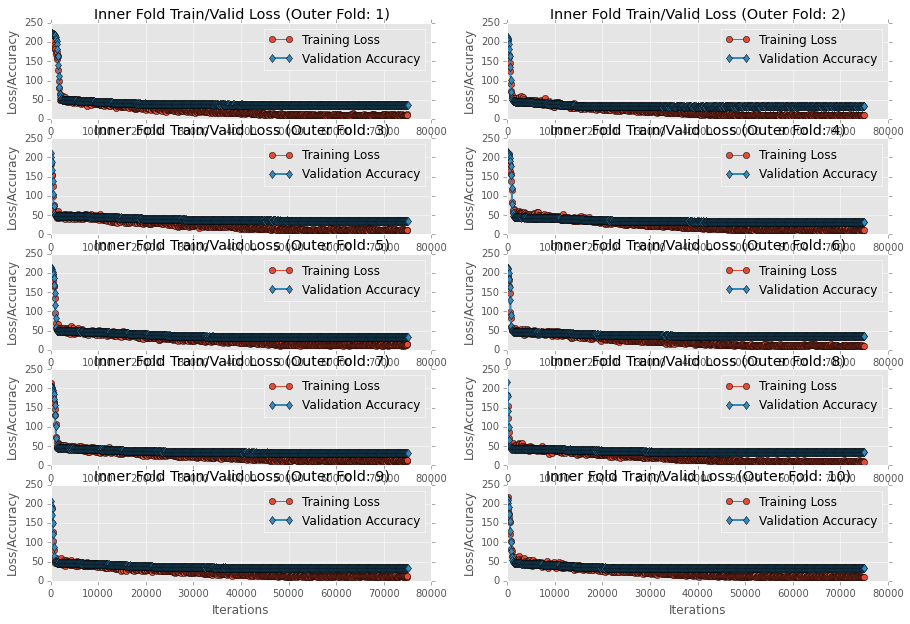

In [97]:
#plt.figure()
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')

baseline_dir= '/projects/nikhil/ADNI_prediction/caffe_output/'
n_folds = 10
n_cols = 2
n_rows = (n_folds+1)/n_cols
tid = 1031
modality = 'HC_CT'

for lid in np.arange(1,n_folds+1,1):  
    #if lid in [1,2,3,4]:
    #    tid = 91
    #else:
    #    tid = 88
    plt.subplot(n_rows,n_cols,lid)
    train_file = '{}OuterFold{}/caffe.INFO.{}_ff_OF{}_{}_T{}'.format(baseline_dir,lid,'train',lid,modality,tid)
    valid_file = '{}OuterFold{}/caffe.INFO.{}_ff_OF{}_{}_T{}'.format(baseline_dir,lid,'test',lid,modality,tid)
    log_title = 'Inner Fold Train/Valid Loss (Outer Fold: {})'.format(lid)
    plot_from_logs(train_file, valid_file, log_title)
    
plt.show()

In [3]:
import caffe

def load_data(data_path, input_node):
    data = tb.open_file(data_path, 'r')
    X = data.get_node('/' + input_node)[:]
    data.close()
    return X


def extract_features(net_file, model_file, target_file, data_path, input_nodes, batch_size):
    os.chdir(os.path.dirname(net_file))
    net = caffe.Net(net_file, model_file, caffe.TEST)        
    
    print net.blobs.items()[0]
    print net.blobs.items()[1]
    
    
    BATCH_SIZE = batch_size    
    N = load_data(data_path, input_nodes[0]).shape[0]
    iters = int(np.ceil(N / float(BATCH_SIZE)))

    code_layer = net.blobs['clas']
    out_shape = code_layer.data.shape    
    X_out = np.zeros(shape=(N, out_shape[1]))
    
    X_list = []
    data_layers = []
    for i, input_node in enumerate(input_nodes):
        X_list.append(load_data(data_path, input_node))
        data_layers.append(net.blobs.items()[i][1])    
        data_layers[i].reshape(BATCH_SIZE, X_list[i].shape[1]) # TODO: only works for 2-D inputs
    
    net.reshape()
        
    print 'Extracting features from data...'
    print 'X_out.shape: {}'.format(X_out.shape)
    
    for i in xrange(iters):
        print '.',
        for m, X in enumerate(X_list):
            X_b = X[i * BATCH_SIZE: (i+1) * BATCH_SIZE,:]
            batch_sampx = X_b.shape[0]
            # Pad last batch with zeros
            if X_b.shape[0] < BATCH_SIZE:
                #print 'Zero-padding last batch with {} rows'.format(BATCH_SIZE-X_b.shape[0])
                X_b = np.vstack((X_b,np.zeros((BATCH_SIZE-X_b.shape[0],X_b.shape[1]))))                       
            
            data_layers[m].data[...] = X_b
            
        net.forward()
        X_out[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer.data[0:batch_sampx,:].copy()

    #np.save(target_file, X_out)
    #print 'Saved to {}'.format(target_file)
    return X_out

In [108]:
#CV perf
baseline_dir= '/projects/nikhil/ADNI_prediction/'
caffe_output_path = baseline_dir + 'caffe_output/'
input_data_dir_path = baseline_dir + 'input_datasets/'
target_file = caffe_output_path + 'test_1'
modality = 'HC_CT'
innerLoop = False
outerLoop = True

n_folds = 10
tid = 1035
batch_size = 256

X_out = []
labels = []

CV_r = []
CV_MSE = []

snapshot_iter = '50000'
# HC_CT_1
# config_dict = {1:['20000','1007'],2:['18000','1006'],3:['10000','1002'],4:['50000','1006'],5:['14000','1004'],
#                6:['12000','1003'],7:['16000','1005'],8:['12000','1003'],9:['8000','1001'],10:['14000','1004']}

# HC_CT_2
config_dict = {1:['50000','1013'],2:['50000','1013'],3:['20000','1007'],4:['50000','1013'],5:['50000','1013'],
               6:['50000','1013'],7:['50000','1013'],8:['50000','1013'],9:['20000','1007'],10:['50000','1013']}

# HC
#config_dict = {1:['28000','357'],2:['28000','357'],3:['14000','350'],4:['14000','350'],5:['12000','349'],
#               6:['16000','351'],7:['20000','353'],8:['14000','350'],9:['12000','349'],10:['24000','355']}
for lid in np.arange(1,n_folds+1,1):
    
    #snapshot_iter = config_dict[lid][0]
    #tid = config_dict[lid][1]   
        
    model_file = '{}OuterFold{}/_iter_{}.caffemodel_{}_T{}'.format(caffe_output_path,lid,snapshot_iter,modality,tid)    
    net_file = '{}OuterFold{}/net_partition.prototxt_{}_T{}'.format(caffe_output_path,lid,modality,tid)
    
    print model_file, net_file
    
    fold_dir = '{}OuterFold{}'.format(caffe_output_path,lid)
    if innerLoop: #Inner fold Validation
        #sub.call(["cp", fold_dir+"/test_inner_val_partition.txt", fold_dir+"/test.txt"])
        input_data = '{}inflated_datasets_C688/HC_CT_inflated_CV_OuterFold_{}_valid_InnerFold_0_partition_ROI_74.h5'.format(input_data_dir_path,lid)
        
        if modality == 'HC':
            input_nodes = ['Fold_{}_X_{}'.format(lid,'L_HC'),'Fold_{}_X_{}'.format(lid,'R_HC')]
        elif modality == 'HC_CT':
            input_nodes = ['Fold_{}_X_{}'.format(lid,'L_HC'),'Fold_{}_X_{}'.format(lid,'R_HC'),
                           'Fold_{}_X_{}'.format(lid,'R_CT')]  #Typo R_CT while creating folds with partition
        else:
            input_nodes = ['Fold_{}_X_{}'.format(lid,modality)]
        
        labels_dataset_name = 'Fold_{}_y'.format(lid)
        label_dataset = h5.File(input_data)                

    elif outerLoop: #Outer fold Validation (fused preferably)
        #sub.call(["cp", fold_dir+"/test_outer_val.txt", fold_dir+"/test.txt"])
        input_data = '{}HC_CT_fused_CV_subsets_C688_valid_ADAS.h5'.format(input_data_dir_path)
                
        if modality == 'HC':
            input_nodes = ['Fold_{}_X_{}'.format(lid,'L_HC'),'Fold_{}_X_{}'.format(lid,'R_HC')]
            
        elif modality == 'HC_CT':            
            input_nodes = ['Fold_{}_X_{}'.format(lid,'L_HC'),'Fold_{}_X_{}'.format(lid,'R_HC'),
                           'Fold_{}_X_{}'.format(lid,'R_CT')]  #Typo R_CT while creating folds with partition
        elif modality == 'CT':            
            input_nodes = ['Fold_{}_X_{}'.format(lid,'R_CT')]
            
        else:            
            input_nodes = ['Fold_{}_X_{}'.format(lid,modality)]
        
        labels_dataset_name = 'Fold_{}_y'.format(lid)
        label_dataset = h5.File(input_data)       
        
    else: 
        print 'unknown validation set'
      
        
    predicted_scores = extract_features(net_file, model_file, target_file, input_data, input_nodes, batch_size).ravel()
    actual_scores = label_dataset[labels_dataset_name][:]
    X_out.append(predicted_scores)
    labels.append(actual_scores)
    CV_r.append(stats.pearsonr(predicted_scores,actual_scores))
    CV_MSE.append(mse(predicted_scores,actual_scores))
    label_dataset.close()
print zip(*CV_r)[0]
print CV_MSE
print np.mean(zip(*CV_r)[0])
print np.median(zip(*CV_r)[0])
print np.median(CV_MSE)

/projects/nikhil/ADNI_prediction/caffe_output/OuterFold1/_iter_50000.caffemodel_HC_CT_T1035 /projects/nikhil/ADNI_prediction/caffe_output/OuterFold1/net_partition.prototxt_HC_CT_T1035
('Fold_1_X_L_HC', <caffe._caffe.Blob object at 0x7f83798a32a8>)
('Fold_1_X_R_HC', <caffe._caffe.Blob object at 0x7f83a60007d0>)
Extracting features from data...
X_out.shape: (59, 1)
. /projects/nikhil/ADNI_prediction/caffe_output/OuterFold2/_iter_50000.caffemodel_HC_CT_T1035 /projects/nikhil/ADNI_prediction/caffe_output/OuterFold2/net_partition.prototxt_HC_CT_T1035
('Fold_2_X_L_HC', <caffe._caffe.Blob object at 0x7f83798a32a8>)
('Fold_2_X_R_HC', <caffe._caffe.Blob object at 0x7f83a60007d0>)
Extracting features from data...
X_out.shape: (58, 1)
. /projects/nikhil/ADNI_prediction/caffe_output/OuterFold3/_iter_50000.caffemodel_HC_CT_T1035 /projects/nikhil/ADNI_prediction/caffe_output/OuterFold3/net_partition.prototxt_HC_CT_T1035
('Fold_3_X_L_HC', <caffe._caffe.Blob object at 0x7f83798a32a8>)
('Fold_3_X_R_HC'

In [37]:
. (0.58688924893898264, 0.40952211243169345, 0.5656060515371456, 0.48480278213788536, 0.55784492599644853, 0.58282301626520305, 0.48146281138315833, 0.54899577290905099, 0.44332089390102525, 0.43364709059681789)
[65.969557146223394, 81.898870688372611, 44.158945855035334, 66.896290448828125, 60.268255298220772, 49.220466958491116, 53.432906094105029, 79.606673299711886, 68.96671211583876, 67.745348907151694]
0.50949147061
0.516899277523
66.4329237975

20k
. (0.54241142759609051, 0.35628311521269479, 0.60940717789017496, 0.46905161567364445, 0.45286890811053337,
   0.5816164274281429, 0.488796373038004, 0.53139398525077475, 0.50555235205409266, 0.39413041188082759)
[87.426180466059336, 96.605444721242321, 43.164683530682481, 74.562445131551584, 89.384029081692049, 
 63.426310425668305, 60.608247517472698, 96.06419313522143, 70.770712014638946, 77.802732739426901]
0.497174362546
76.1825889355

50k
. (0.61077607942359113, 0.52014830633861575, 0.53885860934862895, 0.52839416670556683, 0.66728784125713558, 
   0.6288164922357844, 0.55767211761271107, 0.57344350755904971, 0.4217555385269684, 0.48034989548455054)
[68.57144585506245, 73.214876170093277, 47.382203071426424, 64.468010748810144, 62.781825744138828, 
 48.354950158294301, 50.014482905070139, 79.259470719128871, 71.995364525178545, 64.288618886903194]
0.548265363481
64.3783148179

---------------
18k 352 []
. (0.61788644845424878, 0.3882475265651496, 0.61473750313125619, 0.47844306536980952, 0.64789754613207218,
   0.60661698901689254, 0.56183098321119718, 0.59988302082412959, 0.43545951715436082, 0.4582003543883017)
[74.343574113244287, 108.74242061371983, 41.964898003055666, 66.457467347049302, 49.57936369571641, 
 50.164738470936086, 67.202134127269474, 80.914967649085483, 88.606307497470169, 70.366343517516825]
0.580857002018
68.7842388224

SyntaxError: invalid syntax (<ipython-input-37-08d88d27b923>, line 1)

In [ ]:
12k 349 [5,9]
. (0.56783685573014153, 0.25279325917021311, 0.62800597275738668, 0.48680247923631031, 0.66209961040981191, 
   0.58641423389175784, 0.51198829340124119, 0.60841003694372975, 0.48457154026419336, 0.44942246222720522)
[87.233519944483419, 127.15456735402975, 44.081091653206542, 67.762916847406302, 47.961849807741515, 
 68.746968010683446, 79.869476663940432, 85.854011951391641, 74.841598258096894, 81.569960899350335]
0.539912574566
77.355537461

14k 350 [3,4,8]
. (0.59831902328524778, 0.2999542269536965, 0.63408608657534038, 0.48920595568826747, 0.6607622020108872,
   0.60749883456207776, 0.53529162821586063, 0.61321728403425979, 0.47641516641915849, 0.45658382130394365)
[81.622553769498566, 122.18010430884672, 42.179480360881932, 66.426565528001035, 45.209057981698244, 
 58.323490538773299, 73.742549938373926, 84.418461764353168, 77.734339832301373, 75.605478203371902]
0.566805325751
74.6740140709

16k 351 [6]
. (0.61386065022339786, 0.34204982794479488, 0.62701238315629393, 0.48347575506510138, 0.65419080979498101, 
   0.61390559534730016, 0.55217962779772567, 0.60745836676167408, 0.4592854172821012, 0.45835688636221134)
[77.419564591162128, 115.98582444773851, 41.409077679175404, 66.304847247965554, 56.147726649163133, 
 53.219071165445548, 70.30662723379325, 83.554548817583481, 95.176887039121084, 71.87297359478336]
0.57981899728
71.0898004143

18k 352 []
. (0.61788644845424878, 0.3882475265651496, 0.61473750313125619, 0.47844306536980952, 0.64789754613207218,
   0.60661698901689254, 0.56183098321119718, 0.59988302082412959, 0.43545951715436082, 0.4582003543883017)
[74.343574113244287, 108.74242061371983, 41.964898003055666, 66.457467347049302, 49.57936369571641, 
 50.164738470936086, 67.202134127269474, 80.914967649085483, 88.606307497470169, 70.366343517516825]
0.580857002018
68.7842388224

20k 353 [7]
. (0.61711542188811341, 0.42744681196527046, 0.59912622064086651, 0.47895608774518234, 0.64573451434811624, 
   0.59020390233049791, 0.56231801784496682, 0.58960535818282833, 0.4164485723463604, 0.45715586701903238)
[70.349505859157901, 98.71747577576869, 43.325393318157701, 66.273390529069019, 48.02499870329482, 
 49.748370943584497, 65.802233997376149, 70.329804963972151, 87.469185720293623, 69.078829433042188]
0.575961688014
67.6761099811

22k 354 
. (0.61685574509642627, 0.46106240258794368, 0.58327351653950044, 0.48085282898987924, 0.64464380794439979, 
   0.5722321622909522, 0.55506522293979288, 0.58712742153175312, 0.38203725047012604, 0.4580553462408064)
[69.124426503473245, 91.862412816579948, 42.762004081203415, 65.898610469838403, 45.549725614319193, 
 50.270885979158848, 63.180157626495422, 72.880638466242672, 75.202426189796356, 68.673728236089033]
0.563648692615
67.286169353

24k 355 [10]
. (0.6189245315652665, 0.48969618072070548, 0.57784258415955136, 0.4827045185792983, 0.64422052048283907, 
   0.55473105804114053, 0.54975744151440009, 0.58015786035280581, 0.39645435921358857, 0.4606332845793808)
[69.020935879147018, 87.455917250078059, 43.135181028716858, 65.597573694618717, 53.596676535125567, 
 51.199746362193807, 63.673233850825241, 73.772734461254501, 84.562530586860788, 66.829320743738521]
0.552244249778
66.2134472192

26k 356 
. (0.62363584774562308, 0.51339196271929111, 0.57872444150762592, 0.4872436045047468, 0.64161555575685614,
   0.54100924378449444, 0.55109381806790003, 0.5814927348967488, 0.38580840187488891, 0.46089116504492822)
[66.921067007653235, 81.636218323665645, 42.915327525989689, 65.142485980803968, 46.579791391890652, 
 52.827476409876247, 64.091600356901353, 75.328153254529923, 75.939037284623794, 68.068642326437839]
0.546051530926
66.0317764942

28k 357 [1,2]
. (0.62892986258752548, 0.5290323894287019, 0.56512341840419611, 0.48605443618764471, 0.64512425279233099, 
   0.52959560027305908, 0.55449781395164066, 0.58342701469393354, 0.38398903925934186, 0.46086314294767022)
[67.421897459639993, 78.844096966934913, 47.316616290131201, 65.310089506637198, 50.641535035379398, 
 54.819347829667635, 63.265080443248074, 73.662703249496275, 74.262813945641653, 69.121718351379087]
0.542046707112
66.3659934831



-------------HC-CT --------------------
16k 325 ES fids[2,3,4]
. (0.66843540440751636, 0.57457391802396729, 0.61412909264203475, 0.52026693277630676, 0.59819493719671546, 
   0.60659875796637108, 0.51795145731541248, 0.58974545921792676, 0.38770791046812436, 0.46387859933379871)
[74.833272317617485, 72.346594133571458, 42.457876403983931, 64.603924727461191, 67.824357936331367, 
 49.5262324988038, 60.373097367421089, 90.182320092003096, 98.872740760634912, 81.201394170028919]
0.582159688621
70.085476035


-------------HC-CT --------------------
304 8k
. (0.55906373523029196, 0.29019126856871141, 0.6284637957253717, 0.60739800065842309, 0.58889635554553355, 
   0.60757955829367349, 0.46580606802765256, 0.57054336854857746, 0.4970758168298095, 0.49207676766196778)
[98.720798971026952, 116.16429432826479, 57.636414077760989, 71.770528297625489, 93.413291036602516, 
 64.616482038802133, 66.0794428024967, 108.27504892746316, 90.465999299784741, 92.321830392787035]
0.564803551889
91.3939148463

305 10k
. (0.60374083367584908, 0.35407902851511425, 0.62929210590995754, 0.59133455988521388, 0.6188702800956003,
   0.62501119192152477, 0.48293831645508728, 0.5981372668492746, 0.49495335763345183, 0.50897646042413458)
[90.004742111719693, 107.52213642002731, 53.917036339997594, 66.076376304646601, 93.597128544673282, 
 58.610844344218258, 62.025111665100184, 100.6674503953824, 80.486431422939134, 83.426898954029625]
0.594735913367
81.9566651885

306 12k
. (0.63332568950210399, 0.41459902554248773, 0.62372037617170395, 0.57299913653093393, 0.61862869404668053, 
   0.62852822782477835, 0.48512604843866852, 0.60682638827088353, 0.4776832140251574, 0.51414899080002585)
[83.924908384796495, 100.12283391042064, 52.042879828516654, 76.083461407944824, 72.755642003499318, 
 54.343806390569185, 63.404017318757546, 92.695964606154021, 78.37207777891723, 75.977949745140108]
0.589912762401
76.0307055765

307 14k
. (0.64799089407920707, 0.46525259423934506, 0.61598073450509394, 0.55564018682405836, 0.61726957049946574, 
   0.62132897390603326, 0.49239711883910314, 0.61005842427857171, 0.46066557966429045, 0.50337184801606527)
[73.720154511586671, 94.403492873018919, 49.317863451080896, 70.188503969718397, 94.351387906449901, 
 51.270369639632179, 64.949738740723404, 93.756882731100575, 83.285058553083786, 71.931325019950293]
0.582849305551
72.8257397658

308 16k
. (0.65715386294974831, 0.49843435012875498, 0.60693139075368896, 0.54651871331950619, 0.60715878910391829, 
   0.61011633487867478, 0.48819556322706498, 0.60103737401438551, 0.43597186212273514, 0.48552789453776085)
[80.9350450607554, 90.076359136517539, 47.52030660592348, 72.784773940112046, 67.247709363847591, 
 53.881312948909361, 56.918507584243514, 89.636580853938725, 77.560500937846399, 101.5806336274477]
0.573778043667
75.172637439

309 18k
. (0.66000771337346809, 0.51835990786491482, 0.60218076990142055, 0.53167480077418305, 0.593530771254562, 
   0.59569598550772507, 0.49656067503370843, 0.59268039900027092, 0.43780500559332858, 0.48221887733372476)
[62.726883279465426, 88.64075701712774, 52.31655064743579, 62.239255304685976, 99.912985096768921, 
 62.167210406631945, 62.907927007430864, 79.287935483450497, 98.163787009701863, 85.478642970466936]
0.562177599887
71.0979312454

310 20k
. (0.66489958557882833, 0.52911831426274847, 0.59363863646883808, 0.52734543235313558, 0.59196498951636056, 
   0.57955072944382091, 0.48471142788309696, 0.58474845989487334, 0.41042704011129943, 0.46647909005707883)
[64.90969370211819, 85.635620129547974, 48.347241510621743, 63.098105627561367, 89.578637783465055, 56.324914492355582, 55.507145025568704, 77.928350720597848, 87.992762791617878, 89.576354554526802]
0.554334521853
71.4190222114


16k (HC_CT286)
. (0.60271309655303218, 0.41019704925135403, 0.58214637781607481, 0.57918057964312375, 0.66707379304318581, 
   0.61698649924224636, 0.46683478830596564, 0.56512409133581931, 0.42762757287606773, 0.45985961494831712)
[87.773442448120718, 109.06620042803864, 55.197369404132637, 69.693276321341017, 66.399442457879999, 
 60.121727116110556, 57.74733360235097, 102.88346635841023, 78.121710646828973, 86.017224097942716]
0.572152335489
73.9074934841

15k (HC_CT T226)
. (0.68056036420883526, 0.58984220217454175, 0.59966634445637623, 0.56790953118879339, 0.68430895948638992, 
   0.59362930709460315, 0.48239447970702254, 0.54814818266535148, 0.44082675712506691, 0.42890486122272975)
[61.573265036310282, 81.784642350486038, 49.41970855867546, 67.17832265089767, 63.984273656521161, 
 53.769622713753193, 59.662769274026893, 91.909443052692609, 85.365775295378114, 85.90768060640886]
0.578875866682
65.5812981537

(16k) (HC_CT T275) 
. (0.52149842898543775, 0.55317524073105073, 0.4368756072466965, 0.44936565875399898)
[67.965093210368821, 98.931453562283963, 76.381816076368651, 80.793195610968326]
0.48543204387
78.5875058437




-----------Working HC Config--------------------
HC 317 6k
. (0.61410103970181806, 0.42822652161758845, 0.59239045587229733, 0.4920051980519507, 0.54343122405923194, 0.58711598529488651, 0.56891350316353051, 0.56735325352149646, 0.42243514154267803, 0.44787194330127744)
[91.243578778496854, 101.54632367595195, 66.089240105676794, 90.821219208344218, 91.153235249822387, 63.769787339622141, 61.35644738134279, 104.26581013551417, 83.272766975081353, 89.860901397370228]
0.55539223879
90.3410603029

HC 318 8k
. (0.61171633465738084, 0.45126751715957236, 0.55483203831934158, 0.51800035061960625, 0.59377620595465119, 
   0.55949243812757554, 0.55921645783102447, 0.5569075969023366, 0.37541147441200179, 0.42590394448937746)
[85.148931066092302, 97.571054298541128, 65.316136459070719, 79.839470759222294, 81.891091856571521, 62.058096589874346, 61.371350841410383, 98.09533511387275, 83.122173806064083, 85.942449875011988]
0.555869817611
82.5066328313

HC 319 10k
. (0.59983565419763007, 0.44542580926728614, 0.50410604651304058, 0.5184514824308547, 0.60662016434364519, 
   0.5098879387265377, 0.54867843561911045, 0.5440741594384173, 0.34650708502962213, 0.4057836565297952)
[82.344357201837084, 94.908966558266755, 62.304441420602771, 73.880523740976614, 75.207610746034476, 62.845173001581031, 63.189690140635214, 94.240384212781308, 83.615245552539506, 86.190470205085916]
0.514169710579
78.7759839739



-----------Working CT Config--------------------
tid = 314 (16k)
lr = 0.00001 * 5

CT 20k
 (0.51637591314278353, 0.53914314753645709, 0.51475786426214631, 0.48407008501123211, 0.4888304523330016,
  0.47938195605970679, 0.27839825461947554, 0.52290876184390522, 0.33816903932754139, 0.3897101034261613)
[148.9233759428094, 177.89607548501107, 89.489432624596333, 103.53074501420677, 150.38866721930972,
 81.114100002022354, 93.251425250304976, 135.51051060576421, 102.41751309481381, 163.16598819182175]
0.486450268672
119.52062781

CT 16k 314
. (0.35720603275274021, 0.5510353174135646, 0.47645626938858354, 0.50717145779882311, 0.51396742293827657, 
   0.48026390823632648, 0.28137498473661077, 0.5140039784533833, 0.3326730125288393, 0.42897718103523119)
[166.11869612153779, 93.549944210049759, 93.231751205054266, 101.64917723358774, 71.922442885578221, 
 85.918045915374051, 84.07315346326817, 134.71200357577948, 82.816369199036217, 98.176883785886318]
0.478360088812
93.3908477076

CT 12k
. (0.026888248307694453, 0.55686409292804595, 0.36356841208756463, 0.49005079593304013, 0.54383001323319025, 
   0.42588197791470928, 0.27336992496628942, 0.46365303229105959, 0.33720621800877382, 0.44250217868306307)
[178.74483927516505, 138.19400134672222, 102.95285191665852, 106.18830632295023, 109.33872373082322,
 89.020511300860576, 78.70806660211602, 143.60897794935062, 93.443892027147726, 105.57985874644704]
0.434192078299
105.884082535

In [30]:
#method_labels = ['L_HC', 'R_HC', 'HC', 'HC_CT']
# Remove multiple entries if any.. 
#del boxplot_config_r['HC_CT']
#del boxplot_config_MSE['HC_CT']

boxplot_config_MSE[modality].append(CV_MSE)
boxplot_config_r[modality].append((zip(*CV_r)[0]))
raw_data = {'predicted_CV_scores': X_out, 'actual_CV_scores': labels}
save_plt_data = True
tid='1000x'
if save_plt_data: #save the data to be plotter later.. (montages etc..)
        montage_dir = '/projects/nikhil/ADNI_prediction/caffe_output/montage_data/'        
        output = open('{}CV_corr_data_{}_T{}.pkl'.format(montage_dir,modality,tid), 'wb')
        pickle.dump(boxplot_config_r, output)
        output = open('{}CV_MSE_data_{}_T{}.pkl'.format(montage_dir,modality,tid), 'wb')
        pickle.dump(boxplot_config_MSE, output)
        output = open('{}CV_raw_data_{}_T{}.pkl'.format(montage_dir,modality,tid), 'wb')
        pickle.dump(raw_data, output)
        output.close()

In [ ]:
#Heldout Test Set
baseline_dir= '/projects/nikhil/ADNI_prediction/'
caffe_output_path = baseline_dir + 'caffe_output/'
input_data_dir_path = baseline_dir + 'input_datasets/'
target_file = caffe_output_path + 'test_1'
n_folds = 1
innerLoop = False
modality = 'HC'
heldout = True
tid = '51'
batch_size = 256
X_out = []
labels = []
CV_MSE = []
n_folds = 1
snapshot_iter = '10000'
if heldout: #Heldout testset
    fold_dir = '{}OuterFold0'.format(caffe_output_path)    
    #sub.call(["cp", fold_dir+"/test_heldout.txt", fold_dir+"/test.txt"])
    
    model_file = '{}OuterFold0/_iter_{}.caffemodel_{}_T{}'.format(caffe_output_path,snapshot_iter,modality,tid)
    net_file = '{}OuterFold0/net_partition.prototxt_{}_T{}'.format(caffe_output_path,modality,tid)
        
        
    if modality == 'HC':
        input_data = '{}HC_CT_fused_CV_OuterFolds_test_partition.h5'.format(input_data_dir_path)
        input_nodes = ['heldout_X_{}'.format('L_HC'),'heldout_X_{}'.format('R_HC')]
        
    elif modality == 'HC_CT':
        input_data = '{}HC_CT_fused_heldout_subsets_C691.h5'.format(input_data_dir_path)
        input_nodes = ['heldout_X_{}'.format('L_HC'),'heldout_X_{}'.format('R_HC'),
                        'heldout_X_{}'.format('CT')]  #Typo R_CT while creating folds with partition
    else:
        input_data = '{}HC_CT_fused_CV_OuterFolds_test_partition.h5'.format(input_data_dir_path)
        input_nodes = ['heldout_X_{}'.format(modality)]
        
    labels_dataset_name = 'heldout_y'
    label_dataset = h5.File(input_data) 
        
        
    predicted_scores = extract_features(net_file, model_file, target_file, input_data, input_nodes, batch_size)
    actual_scores = label_dataset[labels_dataset_name][:]
    X_out.append(predicted_scores)
    labels.append(actual_scores)    
    label_dataset.close()
    print mse(predicted_scores,actual_scores)
    print stats.pearsonr(np.squeeze(predicted_scores),np.squeeze(actual_scores))

In [ ]:
# Remove multiple entries if any.. 
#del boxplot_config_r['HC_CT']
#del boxplot_config_MSE['HC_CT']


# HC
#0.58370675778
#71.9999916415

163842 * 2

In [ ]:
# Boxplots for CV statistics (r, mse, R2)
import pandas as pd
stat_measure_list = [boxplot_config_r,boxplot_config_MSE]
stat_measure_names = ['Pearson r', 'MSE']
from matplotlib.artist import setp
plt.figure()
font_small = 12
font_med = 16
font_large = 24
plt.style.use('ggplot')

for sm, stat_measure in enumerate(stat_measure_list):
    plt.subplot(2,1,sm+1)
    df_array = pd.DataFrame(dict([ (k,pd.Series(v[0])) for k,v in stat_measure.iteritems() ]))
    bplot = df_array.boxplot(column=stat_measure.keys(), fontsize=font_large)
    #plt.xlabel('Method',fontsize=font_large)
    plt.ylabel(stat_measure_names[sm],fontsize=font_large)
    plt.xticks(fontsize=font_med)
    plt.yticks(fontsize=font_small)
    setp(bplot['boxes'], linewidth=2)
    setp(bplot['whiskers'], linewidth=2)
    setp(bplot['fliers'], linewidth=2)
    setp(bplot['medians'], linewidth=2)
    
#box_fig = plt.gcf()
#box_fig.savefig('/projects/nikhil/ADNI_prediction/visuals/DeepNet_BoxPlot.png'.format(modality,tid), bbox_inches='tight')

/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


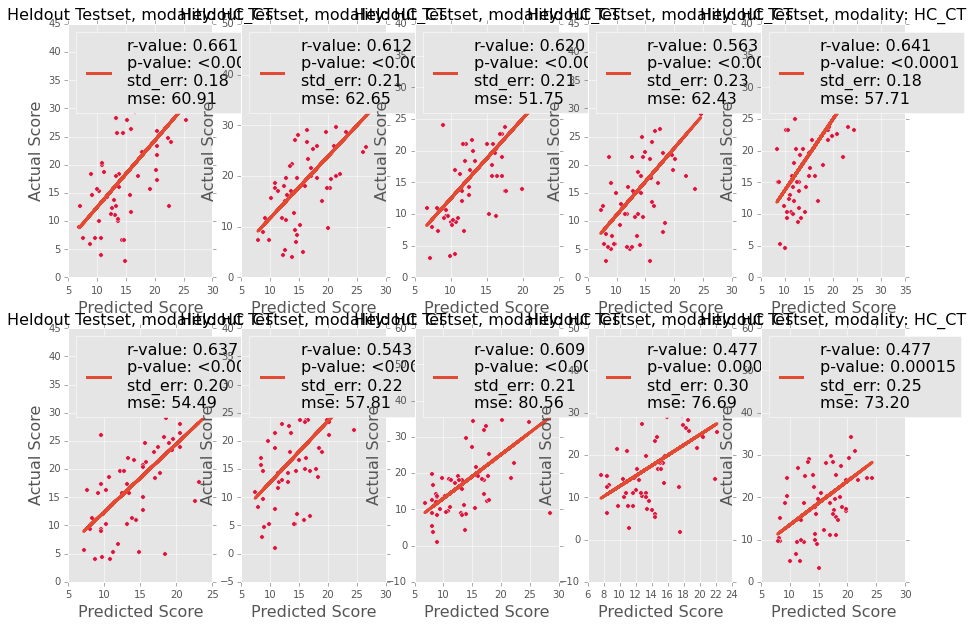

In [21]:
# Plot correlations from the predictions
save_plt_data = False
n_rows = 2
n_cols = (n_folds+1)/n_rows

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.figure()

plt.style.use('ggplot')
font_small = 8
font_med = 16
font_large = 24
r_fold = []
r_pear = []
if innerLoop:
    loop_name = 'Inner Fold' 
else:
    loop_name = 'Outer Fold'

for i in np.arange(n_folds):
    x = np.squeeze(X_out[i])
    y = np.squeeze(labels[i])
    
    if save_plt_data: #save the data to be plotter later.. (montages etc..)
        montage_dir = '/projects/nikhil/ADNI_prediction/caffe_output/montage_data/'
        mydict = {'predicted_score': x, 'actual_score': y}
        output = open('{}corr_data_{}_T{}.pkl'.format(montage_dir,modality,tid), 'wb')
        pickle.dump(mydict, output)
        output.close()
        
    plt.subplot(n_rows,n_cols,i+1)
    #plt.subplot(n_rows,n_cols,2)
    plt.scatter(x, y, c='crimson',s=20)
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit) 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    r_fold.append(r_value)    
    if p_value < 0.0001:
        p_value_sig = '<0.0001'
    else:
        p_value_sig = '{:.5f}'.format(p_value)
        
    label_str = 'r-value: {:04.3f}'.format(r_value) + '\n' + 'p-value: ' + p_value_sig + '\n' + 'std_err: {:04.2f}'.format(std_err) + '\n' + 'mse: {:04.2f}'.format(mse(x,y))
    # fit_fn is now a function which takes in x and returns an estimate for y
    plt.plot(x, fit_fn(x),linewidth=3, label=label_str)
    
    #title_str = '{}: {} Validation'.format(loop_name, i+1) # CV 
    title_str = 'Heldout Testset, modality: {}'.format(modality)  #heldout Test set
    plt.title(title_str,fontsize=font_med)
    plt.xlabel('Predicted Score',fontsize=font_med)
    plt.ylabel('Actual Score',fontsize=font_med)            
    plt.legend(fontsize=font_med,loc=2)
    fig1 = plt.gcf()

#plt.show()
# plt.savefig('/projects/nikhil/ADNI_prediction/visuals/Classification/corr_{}.png'.format(modality), bbox_inches='tight')

In [ ]:
fig1.savefig('/projects/nikhil/ADNI_prediction/visuals/DeepNets_corr_{}_T{}.png'.format(modality,tid), bbox_inches='tight')

In [ ]:
# QC HC volume indexing and correlation with the ADAS score.. must be around -0.25 
import pickle
test_X = load_data('/projects/nikhil/ADNI_prediction/input_datasets/HC_CT_inflated_CV_OuterFolds_test_partition_fused.h5', 'heldout_X_L_HC')
test_y = load_data('/projects/nikhil/ADNI_prediction/input_datasets/HC_CT_inflated_CV_OuterFolds_test_partition_fused.h5', 'heldout_y')
#print stats.pearsonr(x,test_y)
#plt.hist(test_y)
#plt.show()

#fuse_path = '/projects/nikhil/miccai/input_data_comb/data_t300_adcn.h5'
test_fuse_path = '/projects/nikhil/ADNI_prediction/input_datasets/ordered_fused_ad_cn_mci_test.h5'
test_L_HC = load_data(test_fuse_path, 'l_hc_features_fused')
test_R_HC = load_data(test_fuse_path, 'r_hc_features_fused')

val_fuse_path = '/projects/nikhil/ADNI_prediction/input_datasets/ordered_fused_ad_cn_mci_valid.h5'
val_L_HC = load_data(val_fuse_path, 'l_hc_features_fused')
val_R_HC = load_data(val_fuse_path, 'r_hc_features_fused')

train_fuse_path = '/projects/nikhil/ADNI_prediction/input_datasets/ordered_fused_ad_cn_mci_train.h5'
train_L_HC = load_data(train_fuse_path, 'l_hc_features_fused')
train_R_HC = load_data(train_fuse_path, 'r_hc_features_fused')

train_val_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_train_plus_val.pkl'
test_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_test.pkl'

print 'train shape: {}'.format(train_L_HC.shape)
print 'val shape: {}'.format(val_L_HC.shape)

train_val_L_HC = np.vstack((train_L_HC,val_L_HC))

f = open(train_val_file)
train_val_data = pickle.load(f)
f = open(test_file)
test_data = pickle.load(f)

#print test_data['L_HC_VOL']
#print test_data['ADAS13']
print 'pkl file data: {}'.format(stats.pearsonr(test_data['L_HC_VOL'], test_data['ADAS13']))
print 'hdf file data: {}'.format(stats.pearsonr(test_data['L_HC_VOL'], test_y))
print 'this should be 1: {}'.format(stats.pearsonr(test_data['ADAS13'], test_y))

print "train val HC corrleations from HDF files"
hdf_train_L_HC = np.array(np.sum(train_val_L_HC,axis=1))
idx = np.array(np.isfinite(train_val_data['ADAS13']))
#print idx
score = train_val_data['ADAS13']
print 'train_val hdf score shape: {}'.format(score.shape)
score = score[idx]
print 'train_val hdf trunc score shape: {}'.format(score.shape)
hdf_train_L_HC_trunc = hdf_train_L_HC[idx]

print 'hdf_train_L shape {}'.format(hdf_train_L_HC_trunc.shape)
print stats.pearsonr(hdf_train_L_HC_trunc[:490],score[:490])
print stats.pearsonr(hdf_train_L_HC_trunc[490:],score[490:])

print "train val HC corrleations from CSV files"
train_val_data = train_val_data[np.isfinite(train_val_data['ADAS13'])]
print stats.pearsonr(train_val_data['L_HC_VOL'], train_val_data['ADAS13'])
print stats.pearsonr(train_val_data['L_HC_VOL'][:490], train_val_data['ADAS13'][:490])
print stats.pearsonr(train_val_data['L_HC_VOL'][490:], train_val_data['ADAS13'][490:])

print train_val_L_HC.shape, train_val_data['L_HC_VOL'].shape, train_val_data['ADAS13'].shape

#print np.sum(train_val_L_HC,axis=1)
#print zip(np.sum(train_val_L_HC,axis=1), np.array(train_val_data['L_HC_VOL']))


In [ ]:
OF_valid_file = 'HC_CT_inflated_CV_OuterFolds_valid_partition_fused.h5'
heldout_test_file = 'HC_CT_inflated_CV_OuterFolds_test_partition_fused.h5'

print 'valid fused QC'
for i in np.arange(1,11,1):
    val_data_X = load_data(input_data_dir_path + OF_valid_file,'Fold_{}_X_R_HC'.format(i))
    val_data_y = load_data(input_data_dir_path + OF_valid_file,'Fold_{}_y'.format(i))
    print 'r fold {}: {}'.format(i,stats.pearsonr(np.sum(val_data_X,axis=1),val_data_y)) 

print 'test fused QC'
test_data_X = load_data(input_data_dir_path + heldout_test_file,'heldout_X_R_HC')
test_data_y = load_data(input_data_dir_path + heldout_test_file,'heldout_y')
print 'r heldout: {}'.format(stats.pearsonr(np.sum(test_data_X,axis=1),test_data_y)) 

inflated_CV_file = 'inflated_datasets/total_HC_vol_CT_inflated_CV_subsets_ROI_74.h5'

for i in np.arange(1,11,1):
    train_data_X = load_data(input_data_dir_path + inflated_CV_file,'Fold_{}_train_X_L_HC'.format(i))
    train_data_y = load_data(input_data_dir_path + inflated_CV_file,'Fold_{}_train_y'.format(i))    
    val_data_X = load_data(input_data_dir_path + inflated_CV_file,'Fold_{}_valid_X_L_HC'.format(i))
    val_data_y = load_data(input_data_dir_path + inflated_CV_file,'Fold_{}_valid_y'.format(i))
    print 'r fold {}, train:{}, val:{}'.format(i,stats.pearsonr(train_data_X,train_data_y),stats.pearsonr(val_data_X,val_data_y)) 



In [ ]:
#Create Train + Val subset for "Exemplar Model" training
baseline_dir= '/projects/nikhil/ADNI_prediction/input_datasets/inflated_datasets/'
exemplar_train_file = 'HC_CT_inflated_Exemplar_train_partition_subsets_ROI_74.h5'
lid=1
ignore_cols = True

input_data_train_X = load_data(baseline_dir + 'HC_CT_inflated_CV_subsets.h5','Fold_{}_train_X'.format(lid))
input_data_train_y = load_data(baseline_dir + 'HC_CT_inflated_CV_subsets.h5','Fold_{}_train_y'.format(lid))

input_data_valid_X = load_data(baseline_dir + 'HC_CT_inflated_CV_subsets.h5','Fold_{}_valid_X'.format(lid))
input_data_valid_y = load_data(baseline_dir + 'HC_CT_inflated_CV_subsets.h5','Fold_{}_valid_y'.format(lid))

out_train_X_raw = np.vstack((input_data_train_X, input_data_valid_X))
heldout_train_y = np.concatenate((input_data_train_y, input_data_valid_y))

#if you want to remove some CT columes (74 connundrum)
L_HC_offset=11427
R_HC_offset=10519
if ignore_cols:
    ignore_list_CT_idx = list(L_HC_offset + R_HC_offset + np.array([0,29,30,37,38]))
    heldout_train_X = np.delete(out_train_X_raw, np.s_[ignore_list_CT_idx], 1)    
else:
    heldout_train_X = out_train_X_raw

test_fused_data = h5.File(baseline_dir + exemplar_train_file,'a')
test_fused_data.create_dataset('heldout_X_L_HC',data=heldout_train_X[:,:L_HC_offset])
test_fused_data.create_dataset('heldout_X_R_HC',data=heldout_train_X[:,L_HC_offset:L_HC_offset+R_HC_offset])
test_fused_data.create_dataset('heldout_X_CT',data=heldout_train_X[:,L_HC_offset+R_HC_offset:])    
test_fused_data.create_dataset('heldout_y',data=heldout_train_y)
test_fused_data.close()


In [ ]:
from math import sqrt
import numpy as np
import h5py as h5
from scipy.stats.mstats_basic import mquantiles
from sklearn.utils.extmath import randomized_svd
import tables as tb
import sys
import os
#import lmdb
import matplotlib.pyplot as plt
from scipy.stats import describe
from sklearn.manifold import TSNE
from sklearn.decomposition import RandomizedPCA
#from activations import visualize_activations, hinton
from scipy.spatial.distance import dice

def get3DVol(HC_input, HC_shape, input_mask):
    flatvol = np.zeros(np.prod(HC_shape))
    flatvol[input_mask] = HC_input
    vol = flatvol.reshape(-1, HC_shape[2]).T
    return vol

def plot_slices(slice_list, baseline_shape, baseline_mask, llimit=0.01, ulimit=0.99, xmin=200, xmax=1600):
    """
    Plot dem slices.
    :param slice_list:
    :param llimit:
    :param ulimit:
    :param num_slices:
    :param xmin:
    :param xmax:
    :return:
    """
    num_slices = len(slice_list)
    plt.style.use('ggplot')
    plt.figure()
    cols = 2
    rows = num_slices / cols
    plt.cla()
    for j, input in enumerate(slice_list):
        quantiles = mquantiles(input[0], [llimit, ulimit])
        wt_vol = get3DVol(input[0], baseline_shape, baseline_mask)
        plt.subplot(rows, cols, j + 1)
        im = plt.imshow(wt_vol[:, xmin:xmax], cmap=plt.cm.Reds, aspect='auto', interpolation='none', vmin=-.06, vmax=0.06)
        plt.grid()
        plt.title(input[1])
        plt.colorbar()
        im.set_clim(quantiles[0], quantiles[1])
        plt.axis('off')
        
def getDice(X,X_hat):    
    X.astype(int)
    X_hat_r = np.round(X_hat)
    X_hat_r.astype(int)
    d=[]
    for i in np.arange(X.shape[0]):
        d.append(dice(X[i,:],X_hat_r[i,:]))
    return d


In [ ]:
from sklearn.manifold import TSNE
#layer_names = ['encoder1','encoder2','encoder3','code']
layer_names = ['encoder1','encoder2','code']

act_title = 'test_35_T10k.h5'

layer_acts = []
input_file = '/projects/nikhil/miccai/visuals/train_logs/' + act_title
input_data = h5.File(input_file, 'r')
for layer in layer_names:
    layer_acts.append(input_data[layer][:])

X_hat = input_data['output_Sigmoid'][:]
input_data.close()

sampx = np.shape(X_hat)[0]

sim=0
# simulation
if sim==1:
    input_file = '/projects/nikhil/miccai/input_data_comb/HC_sim_cat4_data_2.h5'
    input_data = h5.File(input_file, 'r')
    features = input_data['train_data_1'][:]
    labels = input_data['train_classes_1'][:]
    input_data.close()

    ind0 = np.where(labels[:sampx] == 0)[0]
    ind1 = np.where(labels[:sampx] == 1)[0]
    ind2 = np.where(labels[:sampx] == 2)[0]
    ind3 = np.where(labels[:sampx] == 3)[0]
    
else:
    input_file = '/projects/nikhil/miccai/visuals/train_logs/ad_cn_test.h5'
    input_data = h5.File(input_file, 'r')
    features = input_data['l_hc_features'][:]
    labels = input_data['label'][:]
    input_data.close()
    ind0 = np.where(labels[:sampx] == 0)[0]
    ind1 = np.where(labels[:sampx] == 1)[0]

X = features[:sampx,:]

#recon_dice = getDice(X, X_hat)
#print "mean dice scores of the test sample reconstructions: " + str(np.mean(recon_dice))

    
plt.figure()
for i in np.arange(len(layer_acts)):
    activations = layer_acts[i]
    print layer_names[i] + " :" + str(np.mean(activations))
    if activations.shape[1] != 1:
        tsne = TSNE(n_components=2, random_state=0, init='pca')
        proj = tsne.fit_transform(activations.astype(float))
    else:
        proj = activations
    
    plt.subplot(2,2,i+1)
    plt.scatter(proj[ind0, 0], proj[ind0, 1], c='mediumturquoise', alpha=0.7,label='AD')
    plt.scatter(proj[ind1, 0], proj[ind1, 1], c='slategray', alpha=0.7,label='CN')
    
    if sim==1:
        plt.scatter(proj[ind2, 0], proj[ind2, 1], c='mediumpurple', alpha=0.7,label='grp3')
        plt.scatter(proj[ind3, 0], proj[ind3, 1], c='darksalmon', alpha=0.7,label='grp4')
        
        
    plt.title(layer_names[i] + ' layer activations')
    plt.legend()

plt.show()

In [ ]:
# Visualize inputs vs their reconstructions:
mappings = tb.open_file('/projects/nikhil/miccai/visuals/train_logs/data_mappings.h5', 'r')
baseline_mask = mappings.get_node('/r_datamask')[:]
volmask = mappings.get_node('/r_volmask')[:]
mappings.close()
baseline_shape = volmask.shape

plot_list = []
for x in range(6):
    i = np.random.random_integers(sampx)
    plot_list.append((X[i], 'X {}'.format(i)))
    plot_list.append((np.round(X_hat[i]), 'X_hat {}'.format(i)))
    
plot_slices(plot_list, baseline_shape, baseline_mask)
plt.show()

In [ ]:
a=0.7
plt.figure()
plt.hist(np.sum(features[labels==0],axis=1),alpha=a,normed=1,bins=50,label='AD')
plt.hist(np.sum(features[labels==1],axis=1),alpha=a,normed=1,bins=50,label='CN')
plt.legend()
plt.show()

In [ ]:
# simulation
input_file = '/projects/nikhil/miccai/input_data_comb/HC_sim_cat4_data_2.h5'
input_data = h5.File(input_file, 'r')
features_all = input_data['train_data_1'][:]
labels = input_data['train_classes_1'][:]
input_data.close()
#Missing HC cases :-P 
vols = np.sum(features_all,axis=1)
empty_rows = np.where(vols!=0)[0]
features = features_all[empty_rows,:]

In [ ]:
#PCA
from sklearn.decomposition import RandomizedPCA
from sklearn.externals import joblib
n_components=64
train_pca = RandomizedPCA(n_components=n_components).fit(features)
features_loadings = train_pca.transform(features)    

In [ ]:
pca_dice=[]
for i in np.arange(5):
    print i        
    feature_recon = np.dot(features_loadings[:,:i],train_pca.components_[:i,:]) + train_pca.mean_
    pca_dice.append(np.nanmean(getDice(features,feature_recon)))

In [ ]:
36000/128